In [1]:
# Bandits

In [2]:
import warnings ; warnings.filterwarnings('ignore')

import gym
import gym_bandits
import numpy as np
from scipy.special import softmax as softmax_fn
from pprint import pprint
from tqdm import tqdm_notebook as tqdm

from itertools import cycle

import sys
import random
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
SEEDS = (12, 34, 56, 78, 90)

%matplotlib inline

In [3]:
plt.style.use('fivethirtyeight')
params = {
    'figure.figsize': (15, 8),
    'font.size': 24,
    'legend.fontsize': 20,
    'axes.titlesize': 28,
    'axes.labelsize': 24,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20
}
pylab.rcParams.update(params)
np.set_printoptions(suppress=True)

# Baseline strategies

In [4]:
def pure_exploitation(env, n_episodes=1000):
    Q = np.zeros((env.action_space.n), dtype=np.float64)
    N = np.zeros((env.action_space.n), dtype=np.int)

    Qe = np.empty((n_episodes, env.action_space.n), dtype=np.float64)
    returns = np.empty(n_episodes, dtype=np.float64)
    actions = np.empty(n_episodes, dtype=np.int)
    name = 'Pure exploitation'
    for e in tqdm(range(n_episodes), 
                  desc='Episodes for: ' + name, 
                  leave=False):
        action = np.argmax(Q)

        _, reward, _, _ = env.step(action)
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]
        
        Qe[e] = Q
        returns[e] = reward
        actions[e] = action
    return name, returns, Qe, actions

In [5]:
def pure_exploration(env, n_episodes=1000):
    Q = np.zeros((env.action_space.n), dtype=np.float64)
    N = np.zeros((env.action_space.n), dtype=np.int)

    Qe = np.empty((n_episodes, env.action_space.n), dtype=np.float64)
    returns = np.empty(n_episodes, dtype=np.float64)
    actions = np.empty(n_episodes, dtype=np.int)
    name = 'Pure exploration'
    for e in tqdm(range(n_episodes), 
                  desc='Episodes for: ' + name, 
                  leave=False):
        action = np.random.randint(len(Q))
        
        _, reward, _, _ = env.step(action)
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]
        
        Qe[e] = Q
        returns[e] = reward
        actions[e] = action
    return name, returns, Qe, actions

# Simple strategies

In [6]:
def epsilon_greedy(env, epsilon=0.01, n_episodes=1000):
    Q = np.zeros((env.action_space.n), dtype=np.float64)
    N = np.zeros((env.action_space.n), dtype=np.int)

    Qe = np.empty((n_episodes, env.action_space.n), dtype=np.float64)
    returns = np.empty(n_episodes, dtype=np.float64)
    actions = np.empty(n_episodes, dtype=np.int)
    name = 'E-greedy {}'.format(epsilon)
    for e in tqdm(range(n_episodes), 
                  desc='Episodes for: ' + name, 
                  leave=False):
        if np.random.uniform() > epsilon:
            action = np.argmax(Q)
        else:
            action = np.random.randint(len(Q))

        _, reward, _, _ = env.step(action)
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]
        
        Qe[e] = Q
        returns[e] = reward
        actions[e] = action
    return name, returns, Qe, actions

In [7]:
def lin_dec_epsilon_greedy(env,
                           init_epsilon=1.0,
                           min_epsilon=0.01, 
                           decay_ratio=0.05, 
                           n_episodes=1000):
    Q = np.zeros((env.action_space.n), dtype=np.float64)
    N = np.zeros((env.action_space.n), dtype=np.int)

    Qe = np.empty((n_episodes, env.action_space.n), dtype=np.float64)
    returns = np.empty(n_episodes, dtype=np.float64)
    actions = np.empty(n_episodes, dtype=np.int)
    name = 'Lin e-greedy {} {} {}'.format(init_epsilon, 
                                          min_epsilon, 
                                          decay_ratio)
    for e in tqdm(range(n_episodes), 
                  desc='Episodes for: ' + name, 
                  leave=False):
        decay_episodes = n_episodes * decay_ratio
        epsilon = 1 - e / decay_episodes
        epsilon *= init_epsilon - min_epsilon
        epsilon += min_epsilon
        epsilon = np.clip(epsilon, min_epsilon, init_epsilon)
        if np.random.uniform() > epsilon:
            action = np.argmax(Q)
        else:
            action = np.random.randint(len(Q))

        _, reward, _, _ = env.step(action)
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]
        
        Qe[e] = Q
        returns[e] = reward
        actions[e] = action
    return name, returns, Qe, actions

In [8]:
def exp_dec_epsilon_greedy(env, 
                           init_epsilon=1.0,
                           min_epsilon=0.01,
                           decay_ratio=0.1,
                           n_episodes=1000):
    Q = np.zeros((env.action_space.n), dtype=np.float64)
    N = np.zeros((env.action_space.n), dtype=np.int)

    Qe = np.empty((n_episodes, env.action_space.n), dtype=np.float64)
    returns = np.empty(n_episodes, dtype=np.float64)
    actions = np.empty(n_episodes, dtype=np.int)

    decay_episodes = int(n_episodes * decay_ratio)
    rem_episodes = n_episodes - decay_episodes
    epsilons = 0.01
    epsilons /= np.logspace(-2, 0, decay_episodes)
    epsilons *= init_epsilon - min_epsilon
    epsilons += min_epsilon
    epsilons = np.pad(epsilons, (0, rem_episodes), 'edge')
    name = 'Exp e-greedy {} {} {}'.format(init_epsilon, 
                                          min_epsilon, 
                                          decay_ratio)
    for e in tqdm(range(n_episodes), 
                  desc='Episodes for: ' + name, 
                  leave=False):
        if np.random.uniform() > epsilons[e]:
            action = np.argmax(Q)
        else:
            action = np.random.randint(len(Q))

        _, reward, _, _ = env.step(action)
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]
        
        Qe[e] = Q
        returns[e] = reward
        actions[e] = action
    return name, returns, Qe, actions

In [9]:
def optimistic_initialization(env, 
                              optimistic_estimate=1.0,
                              initial_count=100,
                              n_episodes=1000):
    Q = np.full((env.action_space.n), optimistic_estimate, dtype=np.float64)
    N = np.full((env.action_space.n), initial_count, dtype=np.int)
    
    Qe = np.empty((n_episodes, env.action_space.n), dtype=np.float64)
    returns = np.empty(n_episodes, dtype=np.float64)
    actions = np.empty(n_episodes, dtype=np.int)
    name = 'Optimistic {} {}'.format(optimistic_estimate, 
                                     initial_count)
    for e in tqdm(range(n_episodes), 
                  desc='Episodes for: ' + name, 
                  leave=False):
        action = np.argmax(Q)

        _, reward, _, _ = env.step(action)
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]

        Qe[e] = Q
        returns[e] = reward
        actions[e] = action
    return name, returns, Qe, actions

# 2-armed bandit environments

In [10]:
b2_Vs = []
for seed in SEEDS:
    env_name = 'BanditTwoArmedUniform-v0'
    env = gym.make(env_name, seed=seed) ; env.reset()
    b2_Q = np.array(env.env.p_dist * env.env.r_dist)
    print('2-armed bandit with seed', seed)
    print('Probability of reward:', env.env.p_dist)
    print('Reward:', env.env.r_dist)
    print('Q(.):', b2_Q)
    b2_Vs.append(np.max(b2_Q))
    print('V*:', b2_Vs[-1])
    print()
print('Mean V* across all seeds:', np.mean(b2_Vs))

2-armed bandit with seed 12
Probability of reward: [0.41630234 0.5545003 ]
Reward: [1 1]
Q(.): [0.41630234 0.5545003 ]
V*: 0.5545003042316209

2-armed bandit with seed 34
Probability of reward: [0.88039337 0.56881791]
Reward: [1 1]
Q(.): [0.88039337 0.56881791]
V*: 0.8803933660102791

2-armed bandit with seed 56
Probability of reward: [0.44859284 0.9499771 ]
Reward: [1 1]
Q(.): [0.44859284 0.9499771 ]
V*: 0.9499771030206514

2-armed bandit with seed 78
Probability of reward: [0.53235706 0.84511988]
Reward: [1 1]
Q(.): [0.53235706 0.84511988]
V*: 0.8451198776828125

2-armed bandit with seed 90
Probability of reward: [0.56461729 0.91744039]
Reward: [1 1]
Q(.): [0.56461729 0.91744039]
V*: 0.9174403942290458

Mean V* across all seeds: 0.8294862090348818


# Running simple strategies on 2-armed bandit environments

In [11]:
def b2_run_simple_strategies_experiment(env_name='BanditTwoArmedUniform-v0'):
    results = {}
    experiments = [
        # baseline strategies
        lambda env: pure_exploitation(env),
        lambda env: pure_exploration(env),

        # epsilon greedy
        lambda env: epsilon_greedy(env, epsilon=0.07),
        lambda env: epsilon_greedy(env, epsilon=0.1),

        # epsilon greedy linearly decaying
        lambda env: lin_dec_epsilon_greedy(env, 
                                           init_epsilon=1.0,
                                           min_epsilon=0.0,
                                           decay_ratio=0.1),
        lambda env: lin_dec_epsilon_greedy(env, 
                                           init_epsilon=0.3,
                                           min_epsilon=0.001,
                                           decay_ratio=0.1),

        # epsilon greedy exponentially decaying
        lambda env: exp_dec_epsilon_greedy(env, 
                                           init_epsilon=1.0, 
                                           min_epsilon=0.0,
                                           decay_ratio=0.1),
        lambda env: exp_dec_epsilon_greedy(env, 
                                           init_epsilon=0.3, 
                                           min_epsilon=0.0, 
                                           decay_ratio=0.3),

        # optimistic
        lambda env: optimistic_initialization(env, 
                                              optimistic_estimate=1.0, 
                                              initial_count=10),
        lambda env: optimistic_initialization(env, 
                                              optimistic_estimate=1.0, 
                                              initial_count=50),
    ]
    for env_seed in tqdm(SEEDS, desc='All experiments'):
        env = gym.make(env_name, seed=env_seed) ; env.reset()
        true_Q = np.array(env.env.p_dist * env.env.r_dist)
        opt_V = np.max(true_Q)
        for seed in tqdm(SEEDS, desc='All environments', leave=False):
            for experiment in tqdm(experiments, 
                                   desc='Experiments with seed {}'.format(seed), 
                                   leave=False):
                env.seed(seed) ; np.random.seed(seed) ; random.seed(seed)
                name, Re, Qe, Ae = experiment(env)
                Ae = np.expand_dims(Ae, -1)
                episode_mean_rew = np.cumsum(Re) / (np.arange(len(Re)) + 1)
                Q_selected = np.take_along_axis(
                    np.tile(true_Q, Ae.shape), Ae, axis=1).squeeze()
                regret = opt_V - Q_selected
                cum_regret = np.cumsum(regret)
                if name not in results.keys(): results[name] = {}
                if 'Re' not in results[name].keys(): results[name]['Re'] = []
                if 'Qe' not in results[name].keys(): results[name]['Qe'] = []
                if 'Ae' not in results[name].keys(): results[name]['Ae'] = []
                if 'cum_regret' not in results[name].keys(): 
                    results[name]['cum_regret'] = []
                if 'episode_mean_rew' not in results[name].keys(): 
                    results[name]['episode_mean_rew'] = []

                results[name]['Re'].append(Re)
                results[name]['Qe'].append(Qe)
                results[name]['Ae'].append(Ae)
                results[name]['cum_regret'].append(cum_regret)
                results[name]['episode_mean_rew'].append(episode_mean_rew)
    return results

b2_results_s = b2_run_simple_strategies_experiment()

# Plotting results of simple strategies on 2-armed bandit environments

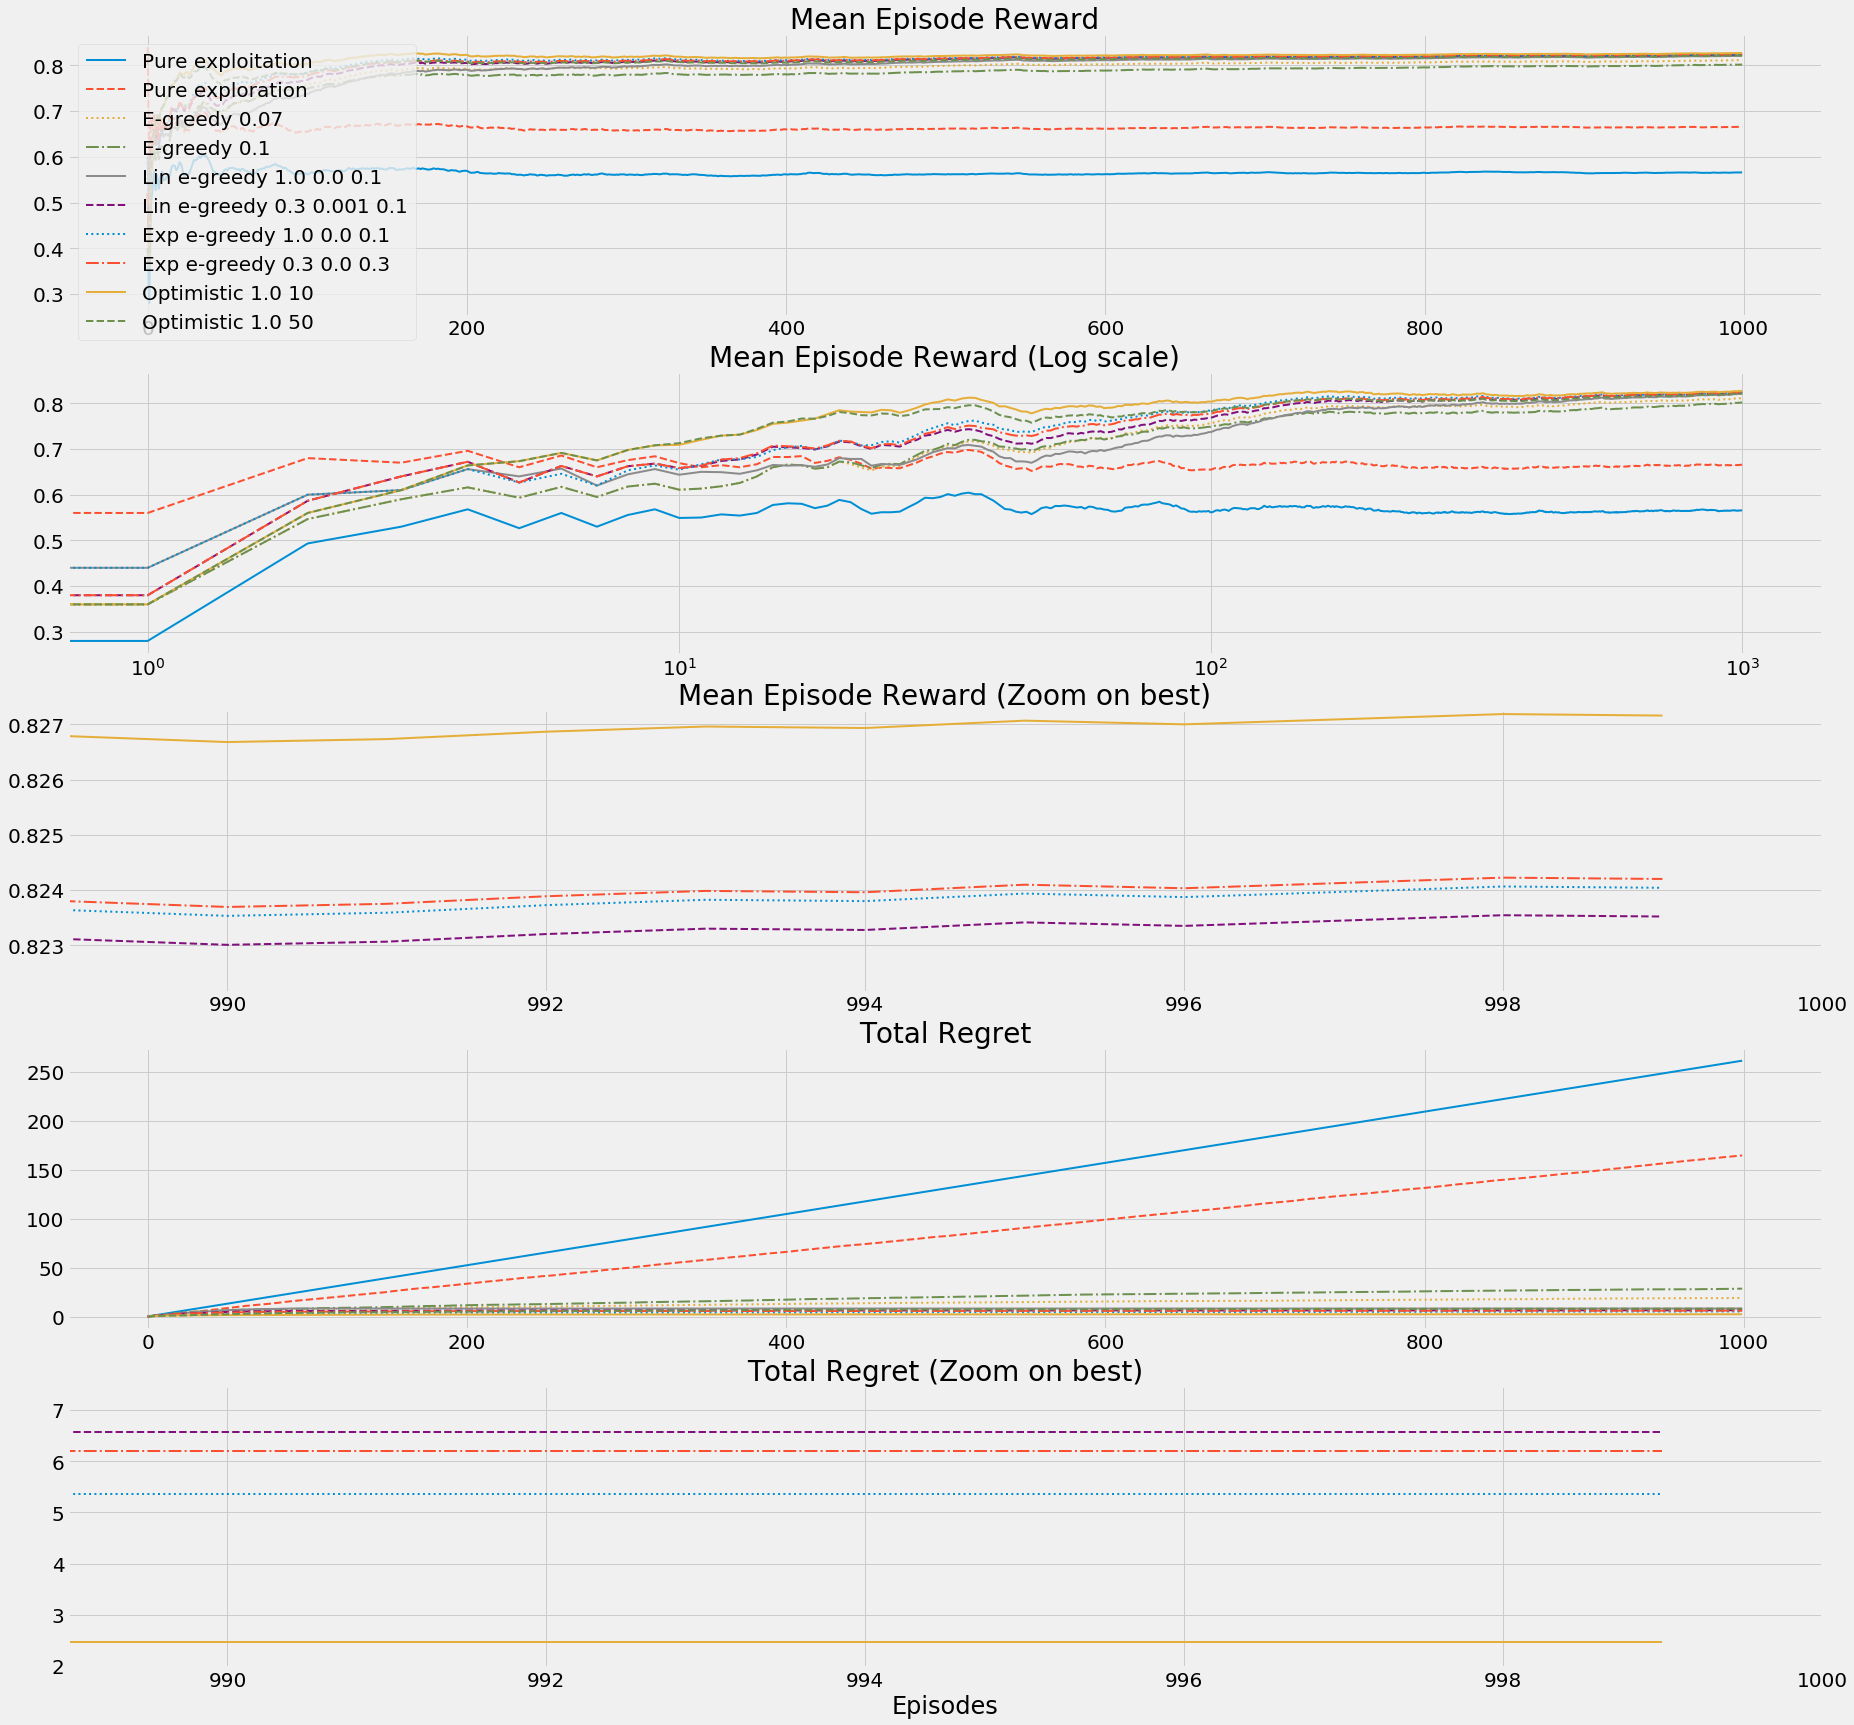

In [12]:
fig, axs = plt.subplots(5, 1, figsize=(28, 28), sharey=False, sharex=False)

lines = ["-","--",":","-."]
linecycler = cycle(lines)
min_reg, max_ret = float('inf'), float('-inf')
for label, result in b2_results_s.items():
    color = next(linecycler)

    # reward
    episode_mean_rew = np.array(result['episode_mean_rew'])
    mean_episode_mean_rew = np.mean(episode_mean_rew, axis=0)

    axs[0].plot(mean_episode_mean_rew, color, linewidth=2, label=label)

    axs[1].plot(mean_episode_mean_rew, color, linewidth=2, label=label)
    axs[1].set_xscale('log')
    
    axs[2].plot(mean_episode_mean_rew, color, linewidth=2, label=label)
    if max_ret < mean_episode_mean_rew[-1]: max_ret = mean_episode_mean_rew[-1]
    axs[2].axis((mean_episode_mean_rew.shape[0]*0.989,
                 mean_episode_mean_rew.shape[0],
                 max_ret-0.005,
                 max_ret+0.0001))

    # regret
    cum_regret = np.array(result['cum_regret'])
    mean_cum_regret = np.mean(cum_regret, axis=0)

    axs[3].plot(mean_cum_regret, color, linewidth=2, label=label)
    
    axs[4].plot(mean_cum_regret, color, linewidth=2, label=label)
    if min_reg > mean_cum_regret[-1]: min_reg = mean_cum_regret[-1]
    plt.axis((mean_cum_regret.shape[0]*0.989,
              mean_cum_regret.shape[0],
              min_reg-0.5,
              min_reg+5))

    # config plot
    axs[0].set_title('Mean Episode Reward')
    axs[1].set_title('Mean Episode Reward (Log scale)')
    axs[2].set_title('Mean Episode Reward (Zoom on best)')
    axs[3].set_title('Total Regret')
    axs[4].set_title('Total Regret (Zoom on best)')
    plt.xlabel('Episodes')
    axs[0].legend(loc='upper left')

plt.show()

# Advanced strategies

In [13]:
def softmax(env, 
            init_temp=float('inf'), 
            min_temp=0.0,
            decay_ratio=0.04,
            n_episodes=1000):
    Q = np.zeros((env.action_space.n), dtype=np.float64)
    N = np.zeros((env.action_space.n), dtype=np.int)

    Qe = np.empty((n_episodes, env.action_space.n), dtype=np.float64)
    returns = np.empty(n_episodes, dtype=np.float64)
    actions = np.empty(n_episodes, dtype=np.int)
    name = 'SoftMax {} {} {}'.format(init_temp, 
                                     min_temp, 
                                     decay_ratio)
    # can't really use infinity
    init_temp = min(init_temp,
                    sys.float_info.max)
    # can't really use zero
    min_temp = max(min_temp,
                   np.nextafter(np.float32(0), 
                                np.float32(1)))
    for e in tqdm(range(n_episodes),
                  desc='Episodes for: ' + name, 
                  leave=False):
        decay_episodes = n_episodes * decay_ratio
        temp = 1 - e / decay_episodes
        temp *= init_temp - min_temp
        temp += min_temp
        temp = np.clip(temp, min_temp, init_temp)

        scaled_Q = Q / temp
        norm_Q = scaled_Q - np.max(scaled_Q)
        exp_Q = np.exp(norm_Q)
        probs = exp_Q / np.sum(exp_Q)
        assert np.isclose(probs.sum(), 1.0)

        action = np.random.choice(np.arange(len(probs)), 
                                  size=1, 
                                  p=probs)[0]

        _, reward, _, _ = env.step(action)
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]
        
        Qe[e] = Q
        returns[e] = reward
        actions[e] = action
    return name, returns, Qe, actions

In [14]:
def upper_confidence_bound(env, 
                           c=2, 
                           n_episodes=1000):
    Q = np.zeros((env.action_space.n), dtype=np.float64)
    N = np.zeros((env.action_space.n), dtype=np.int)
    
    Qe = np.empty((n_episodes, env.action_space.n), dtype=np.float64)
    returns = np.empty(n_episodes, dtype=np.float64)
    actions = np.empty(n_episodes, dtype=np.int)
    name = 'UCB {}'.format(c)
    for e in tqdm(range(n_episodes), 
                  desc='Episodes for: ' + name, 
                  leave=False):
        action = e
        if e >= len(Q):
            U = np.sqrt(c * np.log(e)/N)
            action = np.argmax(Q + U)

        _, reward, _, _ = env.step(action)
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]
        
        Qe[e] = Q
        returns[e] = reward
        actions[e] = action
    return name, returns, Qe, actions

In [15]:
def thompson_sampling(env, 
                      alpha=1,
                      beta=0,
                      n_episodes=1000):
    Q = np.zeros((env.action_space.n), dtype=np.float64)
    N = np.zeros((env.action_space.n), dtype=np.int)
    
    Qe = np.empty((n_episodes, env.action_space.n), dtype=np.float64)
    returns = np.empty(n_episodes, dtype=np.float64)
    actions = np.empty(n_episodes, dtype=np.int)
    name = 'Thompson Sampling {} {}'.format(alpha, beta)
    for e in tqdm(range(n_episodes), 
                  desc='Episodes for: ' + name, 
                  leave=False):
        samples = np.random.normal(
            loc=Q, scale=alpha/(np.sqrt(N) + beta))
        action = np.argmax(samples)

        _, reward, _, _ = env.step(action)
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]

        Qe[e] = Q
        returns[e] = reward
        actions[e] = action
    return name, returns, Qe, actions

# Running advanced strategies on 2-armed bandit environments

In [16]:
def b2_run_advanced_strategies_experiment(env_name='BanditTwoArmedUniform-v0'):
    results = {}
    experiments = [
        # baseline strategies 
        lambda env: pure_exploitation(env),
        lambda env: pure_exploration(env),

        # best from simple strategies
        lambda env: optimistic_initialization(env, 
                                              optimistic_estimate=1.0, 
                                              initial_count=10),
        lambda env: exp_dec_epsilon_greedy(env, 
                                           init_epsilon=0.3, 
                                           min_epsilon=0.0, 
                                           decay_ratio=0.3),

        # softmax
        lambda env: softmax(env, 
                            init_temp=float('inf'), 
                            min_temp=0.0, 
                            decay_ratio=0.005),
        lambda env: softmax(env, 
                            init_temp=100, 
                            min_temp=0.01, 
                            decay_ratio=0.01),

        # ucb
        lambda env: upper_confidence_bound(env, c=0.2),
        lambda env: upper_confidence_bound(env, c=0.5),

        # thompson sampling
        lambda env: thompson_sampling(env, alpha=1, beta=1),
        lambda env: thompson_sampling(env, alpha=0.5, beta=0.5),
    ]
    for env_seed in tqdm(SEEDS, desc='All experiments'):
        env = gym.make(env_name, seed=env_seed) ; env.reset()
        true_Q = np.array(env.env.p_dist * env.env.r_dist)
        opt_V = np.max(true_Q)
        for seed in tqdm(SEEDS, desc='All environments', leave=False):
            for experiment in tqdm(experiments, 
                                   desc='Experiments with seed {}'.format(seed), 
                                   leave=False):
                env.seed(seed) ; np.random.seed(seed) ; random.seed(seed)
                name, Re, Qe, Ae = experiment(env)
                Ae = np.expand_dims(Ae, -1)
                episode_mean_rew = np.cumsum(Re) / (np.arange(len(Re)) + 1)
                Q_selected = np.take_along_axis(
                    np.tile(true_Q, Ae.shape), Ae, axis=1).squeeze()
                regret = opt_V - Q_selected
                cum_regret = np.cumsum(regret)
                if name not in results.keys(): results[name] = {}
                if 'Re' not in results[name].keys(): results[name]['Re'] = []
                if 'Qe' not in results[name].keys(): results[name]['Qe'] = []
                if 'Ae' not in results[name].keys(): results[name]['Ae'] = []
                if 'cum_regret' not in results[name].keys(): 
                    results[name]['cum_regret'] = []
                if 'episode_mean_rew' not in results[name].keys(): 
                    results[name]['episode_mean_rew'] = []

                results[name]['Re'].append(Re)
                results[name]['Qe'].append(Qe)
                results[name]['Ae'].append(Ae)
                results[name]['cum_regret'].append(cum_regret)
                results[name]['episode_mean_rew'].append(episode_mean_rew)
    return results

b2_results_a = b2_run_advanced_strategies_experiment()

# Plotting results of advanced strategies on 2-armed bandit  environments

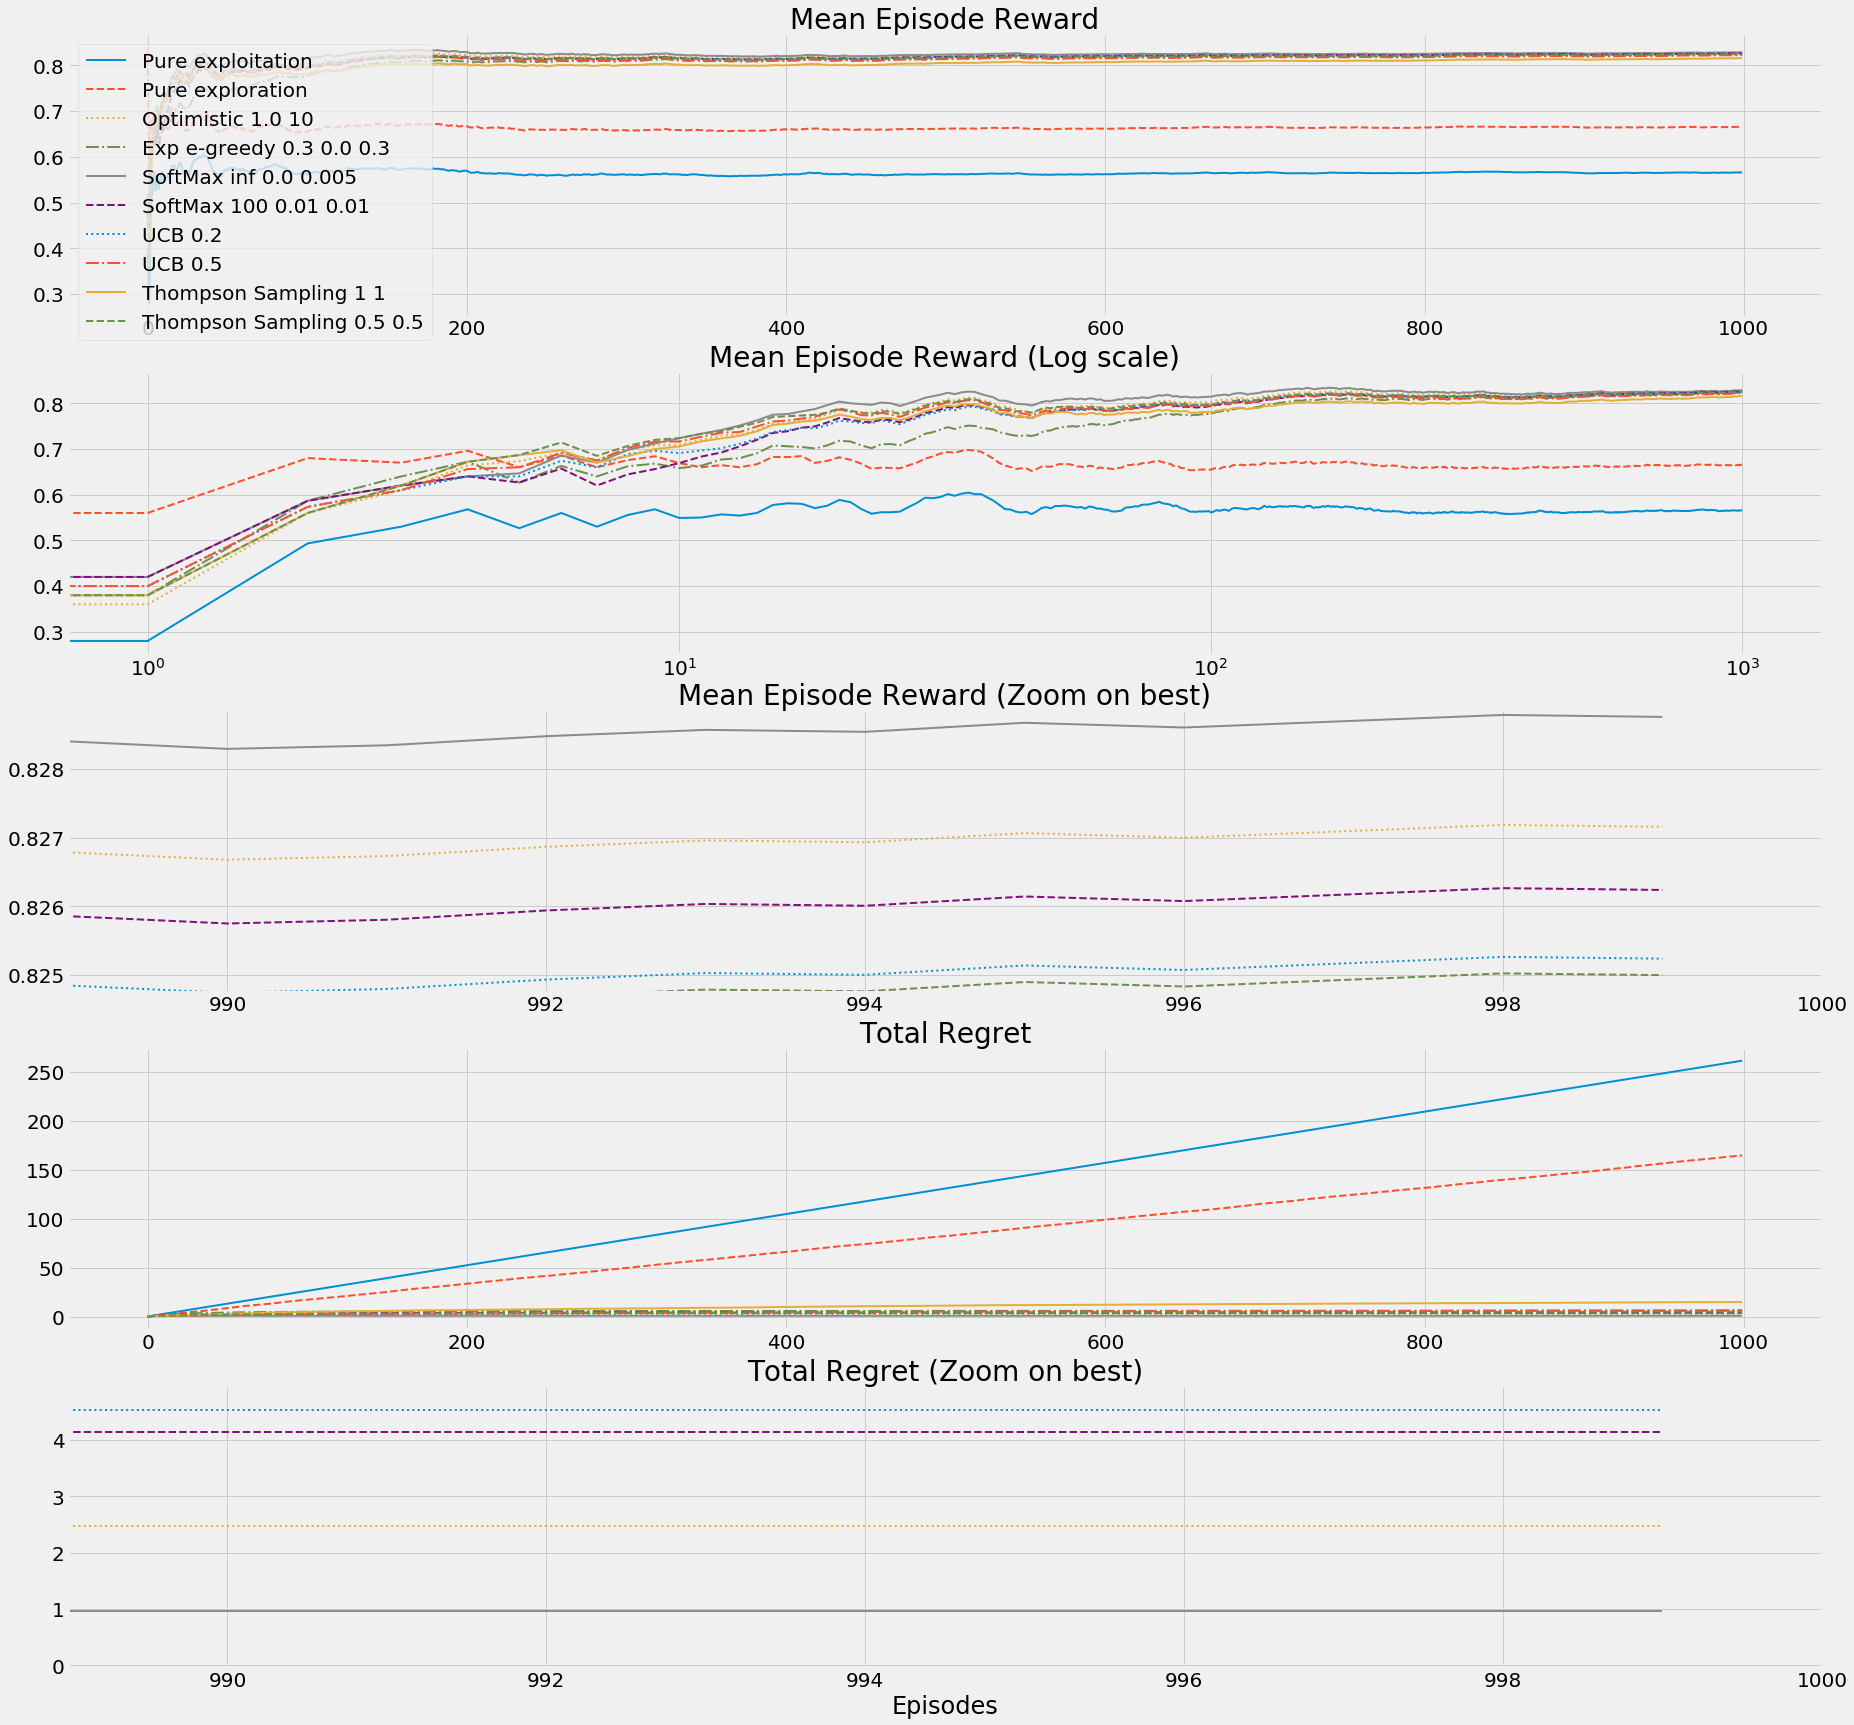

In [17]:
fig, axs = plt.subplots(5, 1, figsize=(28, 28), sharey=False, sharex=False)

lines = ["-","--",":","-."]
linecycler = cycle(lines)
min_reg, max_ret = float('inf'), float('-inf')
for label, result in b2_results_a.items():
    color = next(linecycler)

    # reward
    episode_mean_rew = np.array(result['episode_mean_rew'])
    mean_episode_mean_rew = np.mean(episode_mean_rew, axis=0)

    axs[0].plot(mean_episode_mean_rew, color, linewidth=2, label=label)

    axs[1].plot(mean_episode_mean_rew, color, linewidth=2, label=label)
    axs[1].set_xscale('log')
    
    axs[2].plot(mean_episode_mean_rew, color, linewidth=2, label=label)
    if max_ret < mean_episode_mean_rew[-1]: max_ret = mean_episode_mean_rew[-1]
    axs[2].axis((mean_episode_mean_rew.shape[0]*0.989,
                 mean_episode_mean_rew.shape[0],
                 max_ret-0.004,
                 max_ret+0.0001))

    # regret
    cum_regret = np.array(result['cum_regret'])
    mean_cum_regret = np.mean(cum_regret, axis=0)

    axs[3].plot(mean_cum_regret, color, linewidth=2, label=label)
    
    axs[4].plot(mean_cum_regret, color, linewidth=2, label=label)
    if min_reg > mean_cum_regret[-1]: min_reg = mean_cum_regret[-1]
    plt.axis((mean_cum_regret.shape[0]*0.989,
              mean_cum_regret.shape[0],
              min_reg-1,
              min_reg+4))

    # config plot
    axs[0].set_title('Mean Episode Reward')
    axs[1].set_title('Mean Episode Reward (Log scale)')
    axs[2].set_title('Mean Episode Reward (Zoom on best)')
    axs[3].set_title('Total Regret')
    axs[4].set_title('Total Regret (Zoom on best)')
    plt.xlabel('Episodes')
    axs[0].legend(loc='upper left')
    
plt.show()

# 10-armed Gaussian bandit environments

In [18]:
b10_Vs = []
for seed in SEEDS:
    env_name = 'BanditTenArmedGaussian-v0'
    env = gym.make(env_name, seed=seed) ; env.reset()
    r_dist = np.array(env.env.r_dist)[:,0]
    b10_Q = np.array(env.env.p_dist * r_dist)
    print('10-armed bandit with seed', seed)
    print('Probability of reward:', env.env.p_dist)
    print('Reward:', r_dist)
    print('Q(.):', b10_Q)
    b10_Vs.append(np.max(b10_Q))
    print('V*:', b10_Vs[-1])
    print()
print('Mean V* across all seeds:', np.mean(b10_Vs))

10-armed bandit with seed 12
Probability of reward: [1 1 1 1 1 1 1 1 1 1]
Reward: [ 1.38503828 -2.12704259 -2.04412697 -0.67407396  0.63734453  1.58553551
  2.64476297  0.34536369 -1.3928017  -0.13044506]
Q(.): [ 1.38503828 -2.12704259 -2.04412697 -0.67407396  0.63734453  1.58553551
  2.64476297  0.34536369 -1.3928017  -0.13044506]
V*: 2.6447629665055974

10-armed bandit with seed 34
Probability of reward: [1 1 1 1 1 1 1 1 1 1]
Reward: [ 0.18060298  0.9982891   1.56491649 -0.5319185   0.05065747 -0.38137431
 -0.37199852  0.78790366  1.00121956 -0.00984009]
Q(.): [ 0.18060298  0.9982891   1.56491649 -0.5319185   0.05065747 -0.38137431
 -0.37199852  0.78790366  1.00121956 -0.00984009]
V*: 1.5649164942952658

10-armed bandit with seed 56
Probability of reward: [1 1 1 1 1 1 1 1 1 1]
Reward: [ 0.62499037 -0.07140136  0.92729309  0.04536638  0.84506588 -0.18313555
  0.00476172  1.55827457 -0.87910825 -0.00429599]
Q(.): [ 0.62499037 -0.07140136  0.92729309  0.04536638  0.84506588 -0.18313555


# Running simple strategies on 10-armed bandit environments

In [19]:
def b10_run_simple_strategies_experiment(env_name='BanditTenArmedGaussian-v0'):
    results = {}
    experiments = [
        # baseline strategies
        lambda env: pure_exploitation(env),
        lambda env: pure_exploration(env),

        # epsilon greedy
        lambda env: epsilon_greedy(env, epsilon=0.07),
        lambda env: epsilon_greedy(env, epsilon=0.1),

        # epsilon greedy linearly decaying
        lambda env: lin_dec_epsilon_greedy(env, 
                                           init_epsilon=1.0,
                                           min_epsilon=0.0,
                                           decay_ratio=0.1),
        lambda env: lin_dec_epsilon_greedy(env, 
                                           init_epsilon=0.3,
                                           min_epsilon=0.001,
                                           decay_ratio=0.1),

        # epsilon greedy exponentially decaying
        lambda env: exp_dec_epsilon_greedy(env, 
                                           init_epsilon=1.0, 
                                           min_epsilon=0.0,
                                           decay_ratio=0.1),
        lambda env: exp_dec_epsilon_greedy(env, 
                                           init_epsilon=0.3, 
                                           min_epsilon=0.0, 
                                           decay_ratio=0.3),

        # optimistic
        lambda env: optimistic_initialization(env, 
                                              optimistic_estimate=1.0, 
                                              initial_count=10),
        lambda env: optimistic_initialization(env, 
                                              optimistic_estimate=1.0, 
                                              initial_count=50),
    ]
    for env_seed in tqdm(SEEDS, desc='All experiments'):
        env = gym.make(env_name, seed=env_seed) ; env.reset()
        r_dist = np.array(env.env.r_dist)[:,0]
        true_Q = np.array(env.env.p_dist * r_dist)
        opt_V = np.max(true_Q)
        for seed in tqdm(SEEDS, desc='All environments', leave=False):
            for experiment in tqdm(experiments, 
                                   desc='Experiments with seed {}'.format(seed), 
                                   leave=False):
                env.seed(seed) ; np.random.seed(seed) ; random.seed(seed)
                name, Re, Qe, Ae = experiment(env)
                Ae = np.expand_dims(Ae, -1)
                episode_mean_rew = np.cumsum(Re) / (np.arange(len(Re)) + 1)
                Q_selected = np.take_along_axis(
                    np.tile(true_Q, Ae.shape), Ae, axis=1).squeeze()
                regret = opt_V - Q_selected
                cum_regret = np.cumsum(regret)
                if name not in results.keys(): results[name] = {}
                if 'Re' not in results[name].keys(): results[name]['Re'] = []
                if 'Qe' not in results[name].keys(): results[name]['Qe'] = []
                if 'Ae' not in results[name].keys(): results[name]['Ae'] = []
                if 'cum_regret' not in results[name].keys(): 
                    results[name]['cum_regret'] = []
                if 'episode_mean_rew' not in results[name].keys(): 
                    results[name]['episode_mean_rew'] = []

                results[name]['Re'].append(Re)
                results[name]['Qe'].append(Qe)
                results[name]['Ae'].append(Ae)
                results[name]['cum_regret'].append(cum_regret)
                results[name]['episode_mean_rew'].append(episode_mean_rew)
    return results

b10_results_s = b10_run_simple_strategies_experiment()

# Plotting results of simple strategies on 10-armed bandit environments

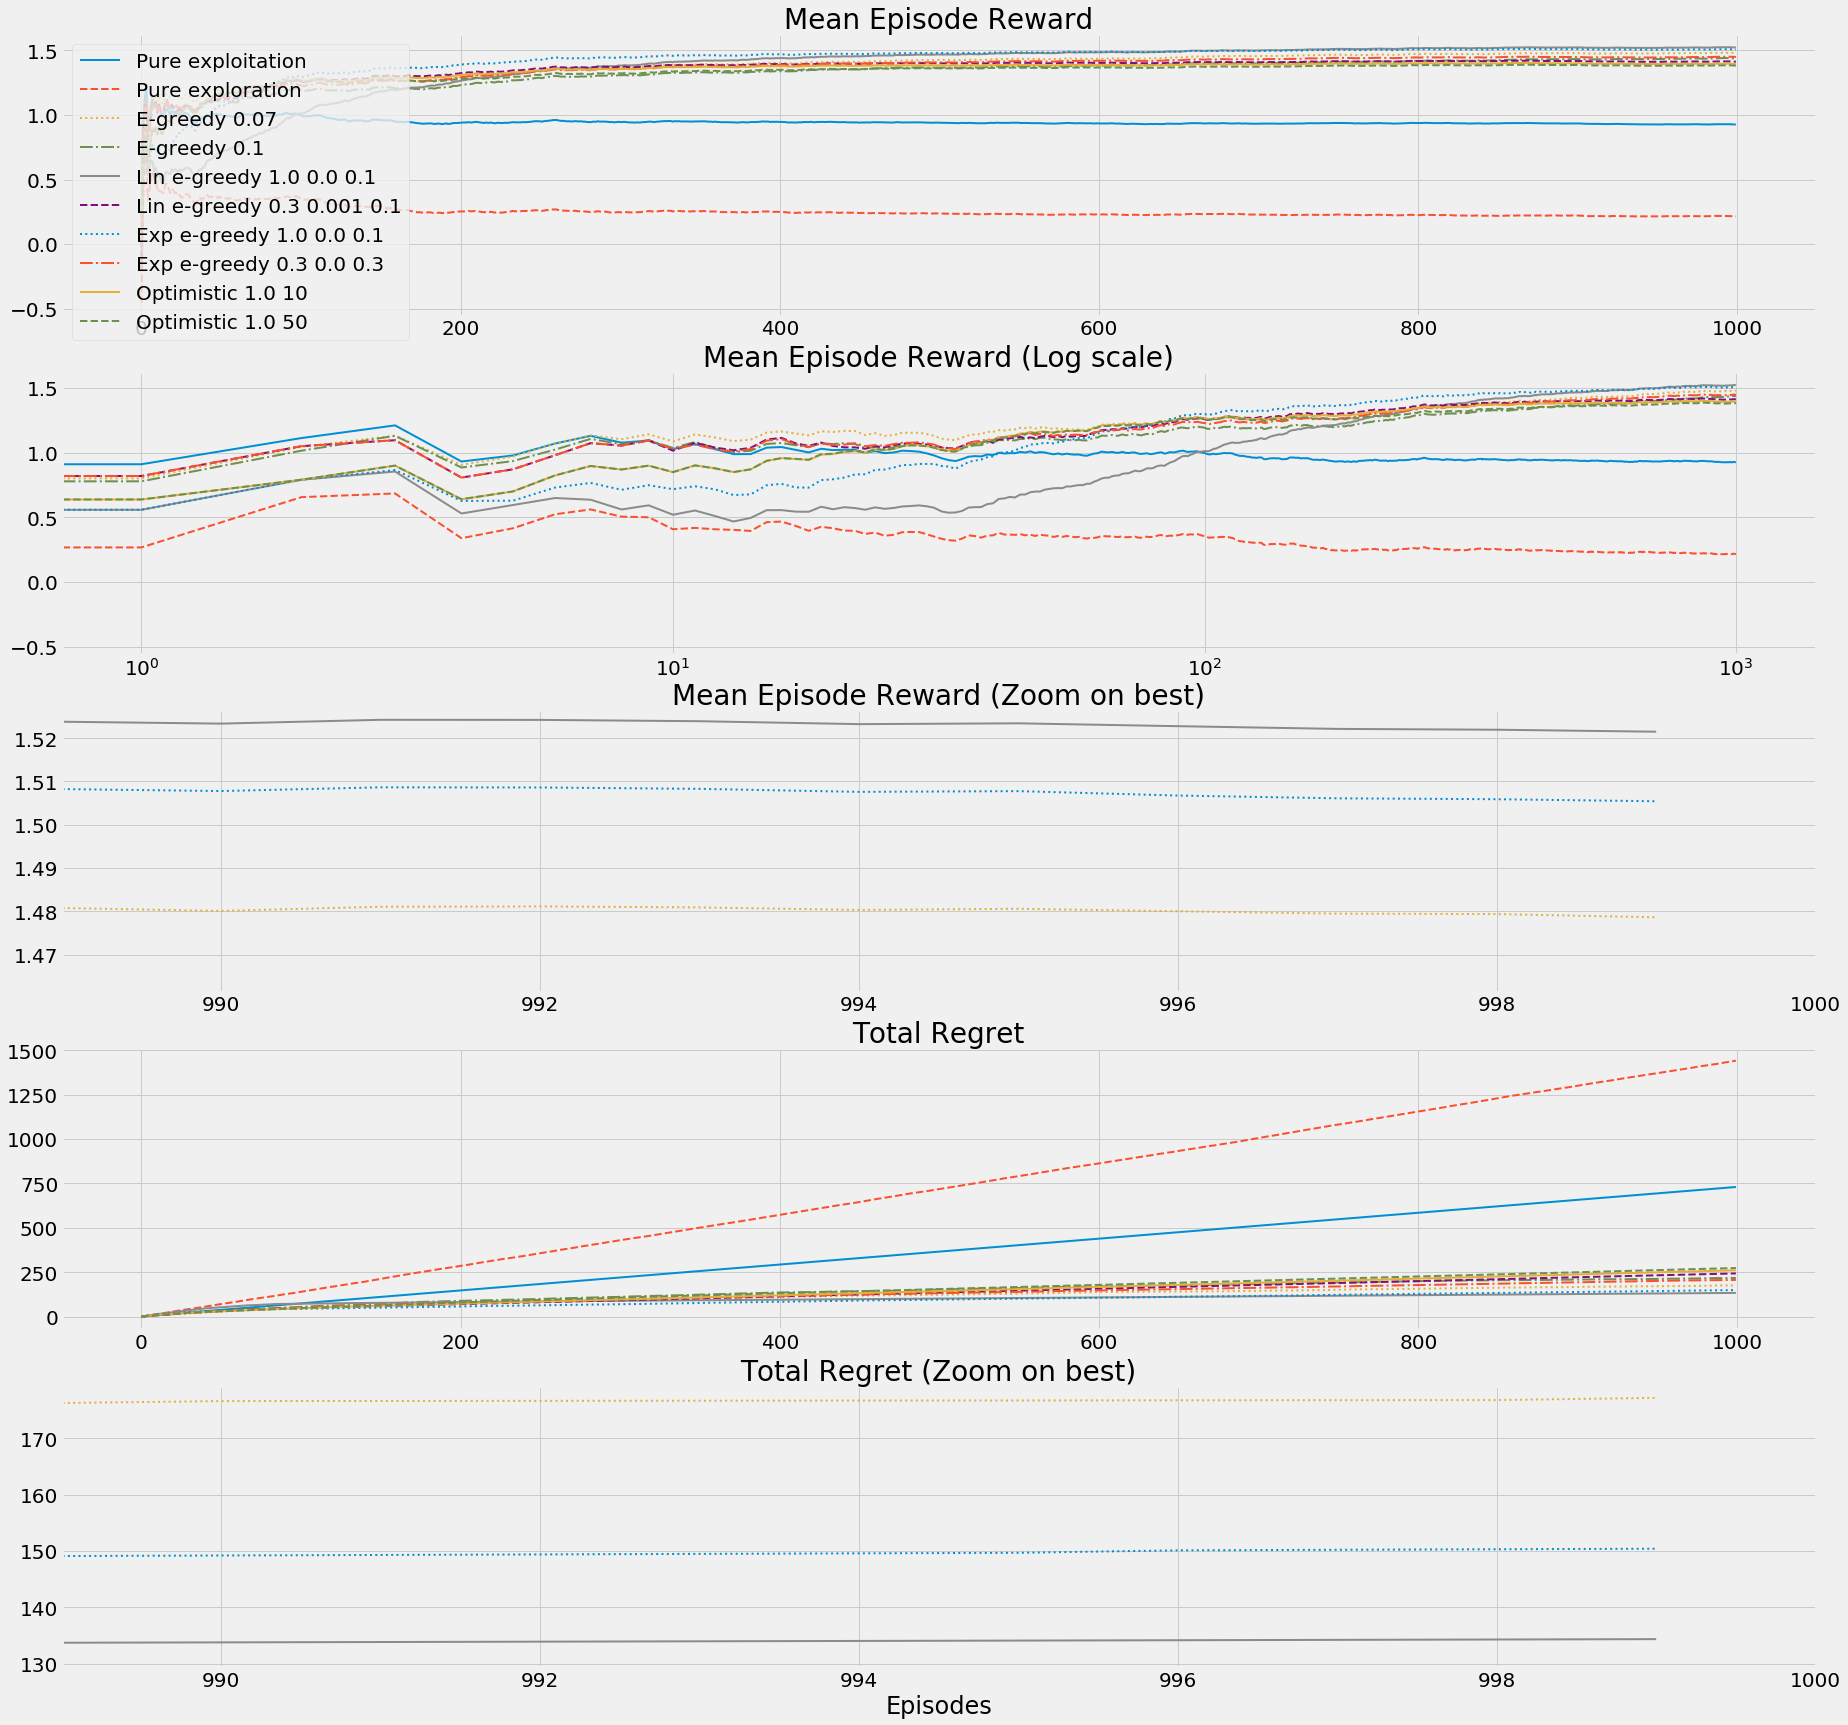

In [20]:
fig, axs = plt.subplots(5, 1, figsize=(28, 28), sharey=False, sharex=False)

lines = ["-","--",":","-."]
linecycler = cycle(lines)
min_reg, max_ret = float('inf'), float('-inf')
for label, result in b10_results_s.items():
    color = next(linecycler)

    # reward
    episode_mean_rew = np.array(result['episode_mean_rew'])
    mean_episode_mean_rew = np.mean(episode_mean_rew, axis=0)

    axs[0].plot(mean_episode_mean_rew, color, linewidth=2, label=label)

    axs[1].plot(mean_episode_mean_rew, color, linewidth=2, label=label)
    axs[1].set_xscale('log')
    
    axs[2].plot(mean_episode_mean_rew, color, linewidth=2, label=label)
    if max_ret < mean_episode_mean_rew[-1]: max_ret = mean_episode_mean_rew[-1]
    axs[2].axis((mean_episode_mean_rew.shape[0]*0.989,
                 mean_episode_mean_rew.shape[0],
                 max_ret-0.06,
                 max_ret+0.005))

    # regret
    cum_regret = np.array(result['cum_regret'])
    mean_cum_regret = np.mean(cum_regret, axis=0)

    axs[3].plot(mean_cum_regret, color, linewidth=2, label=label)
    
    axs[4].plot(mean_cum_regret, color, linewidth=2, label=label)
    if min_reg > mean_cum_regret[-1]: min_reg = mean_cum_regret[-1]
    plt.axis((mean_cum_regret.shape[0]*0.989,
              mean_cum_regret.shape[0],
              min_reg-5,
              min_reg+45))

    # config plot
    axs[0].set_title('Mean Episode Reward')
    axs[1].set_title('Mean Episode Reward (Log scale)')
    axs[2].set_title('Mean Episode Reward (Zoom on best)')
    axs[3].set_title('Total Regret')
    axs[4].set_title('Total Regret (Zoom on best)')
    plt.xlabel('Episodes')
    axs[0].legend(loc='upper left')

plt.show()

# Running advanced strategies on 10-armed bandit environments

In [21]:
def b10_run_advanced_strategies_experiment(env_name='BanditTenArmedGaussian-v0'):
    results = {}
    experiments = [
        # baseline strategies 
        lambda env: pure_exploitation(env),
        lambda env: pure_exploration(env),

        # best from simple strategies
        lambda env: lin_dec_epsilon_greedy(env, 
                                           init_epsilon=1.0,
                                           min_epsilon=0.0,
                                           decay_ratio=0.1),
        lambda env: exp_dec_epsilon_greedy(env, 
                                           init_epsilon=1.0, 
                                           min_epsilon=0.0,
                                           decay_ratio=0.1),

        # softmax
        lambda env: softmax(env, 
                            init_temp=float('inf'), 
                            min_temp=0.0, 
                            decay_ratio=0.005),
        lambda env: softmax(env, 
                            init_temp=100, 
                            min_temp=0.01, 
                            decay_ratio=0.01),

        # ucb
        lambda env: upper_confidence_bound(env, c=0.2),
        lambda env: upper_confidence_bound(env, c=0.5),

        # thompson sampling
        lambda env: thompson_sampling(env, alpha=1, beta=1),
        lambda env: thompson_sampling(env, alpha=0.5, beta=0.5),
    ]
    for env_seed in tqdm(SEEDS, desc='All experiments'):
        env = gym.make(env_name, seed=env_seed) ; env.reset()
        r_dist = np.array(env.env.r_dist)[:,0]
        true_Q = np.array(env.env.p_dist * r_dist)
        opt_V = np.max(true_Q)
        for seed in tqdm(SEEDS, desc='All environments', leave=False):
            for experiment in tqdm(experiments, 
                                   desc='Experiments with seed {}'.format(seed), 
                                   leave=False):
                env.seed(seed) ; np.random.seed(seed) ; random.seed(seed)
                name, Re, Qe, Ae = experiment(env)
                Ae = np.expand_dims(Ae, -1)
                episode_mean_rew = np.cumsum(Re) / (np.arange(len(Re)) + 1)
                Q_selected = np.take_along_axis(
                    np.tile(true_Q, Ae.shape), Ae, axis=1).squeeze()
                regret = opt_V - Q_selected
                cum_regret = np.cumsum(regret)
                if name not in results.keys(): results[name] = {}
                if 'Re' not in results[name].keys(): results[name]['Re'] = []
                if 'Qe' not in results[name].keys(): results[name]['Qe'] = []
                if 'Ae' not in results[name].keys(): results[name]['Ae'] = []
                if 'cum_regret' not in results[name].keys(): 
                    results[name]['cum_regret'] = []
                if 'episode_mean_rew' not in results[name].keys():
                    results[name]['episode_mean_rew'] = []

                results[name]['Re'].append(Re)
                results[name]['Qe'].append(Qe)
                results[name]['Ae'].append(Ae)
                results[name]['cum_regret'].append(cum_regret)
                results[name]['episode_mean_rew'].append(episode_mean_rew)
    return results

b10_results_a = b10_run_advanced_strategies_experiment()

# Plotting results of advanced strategies on 10-armed bandit environments

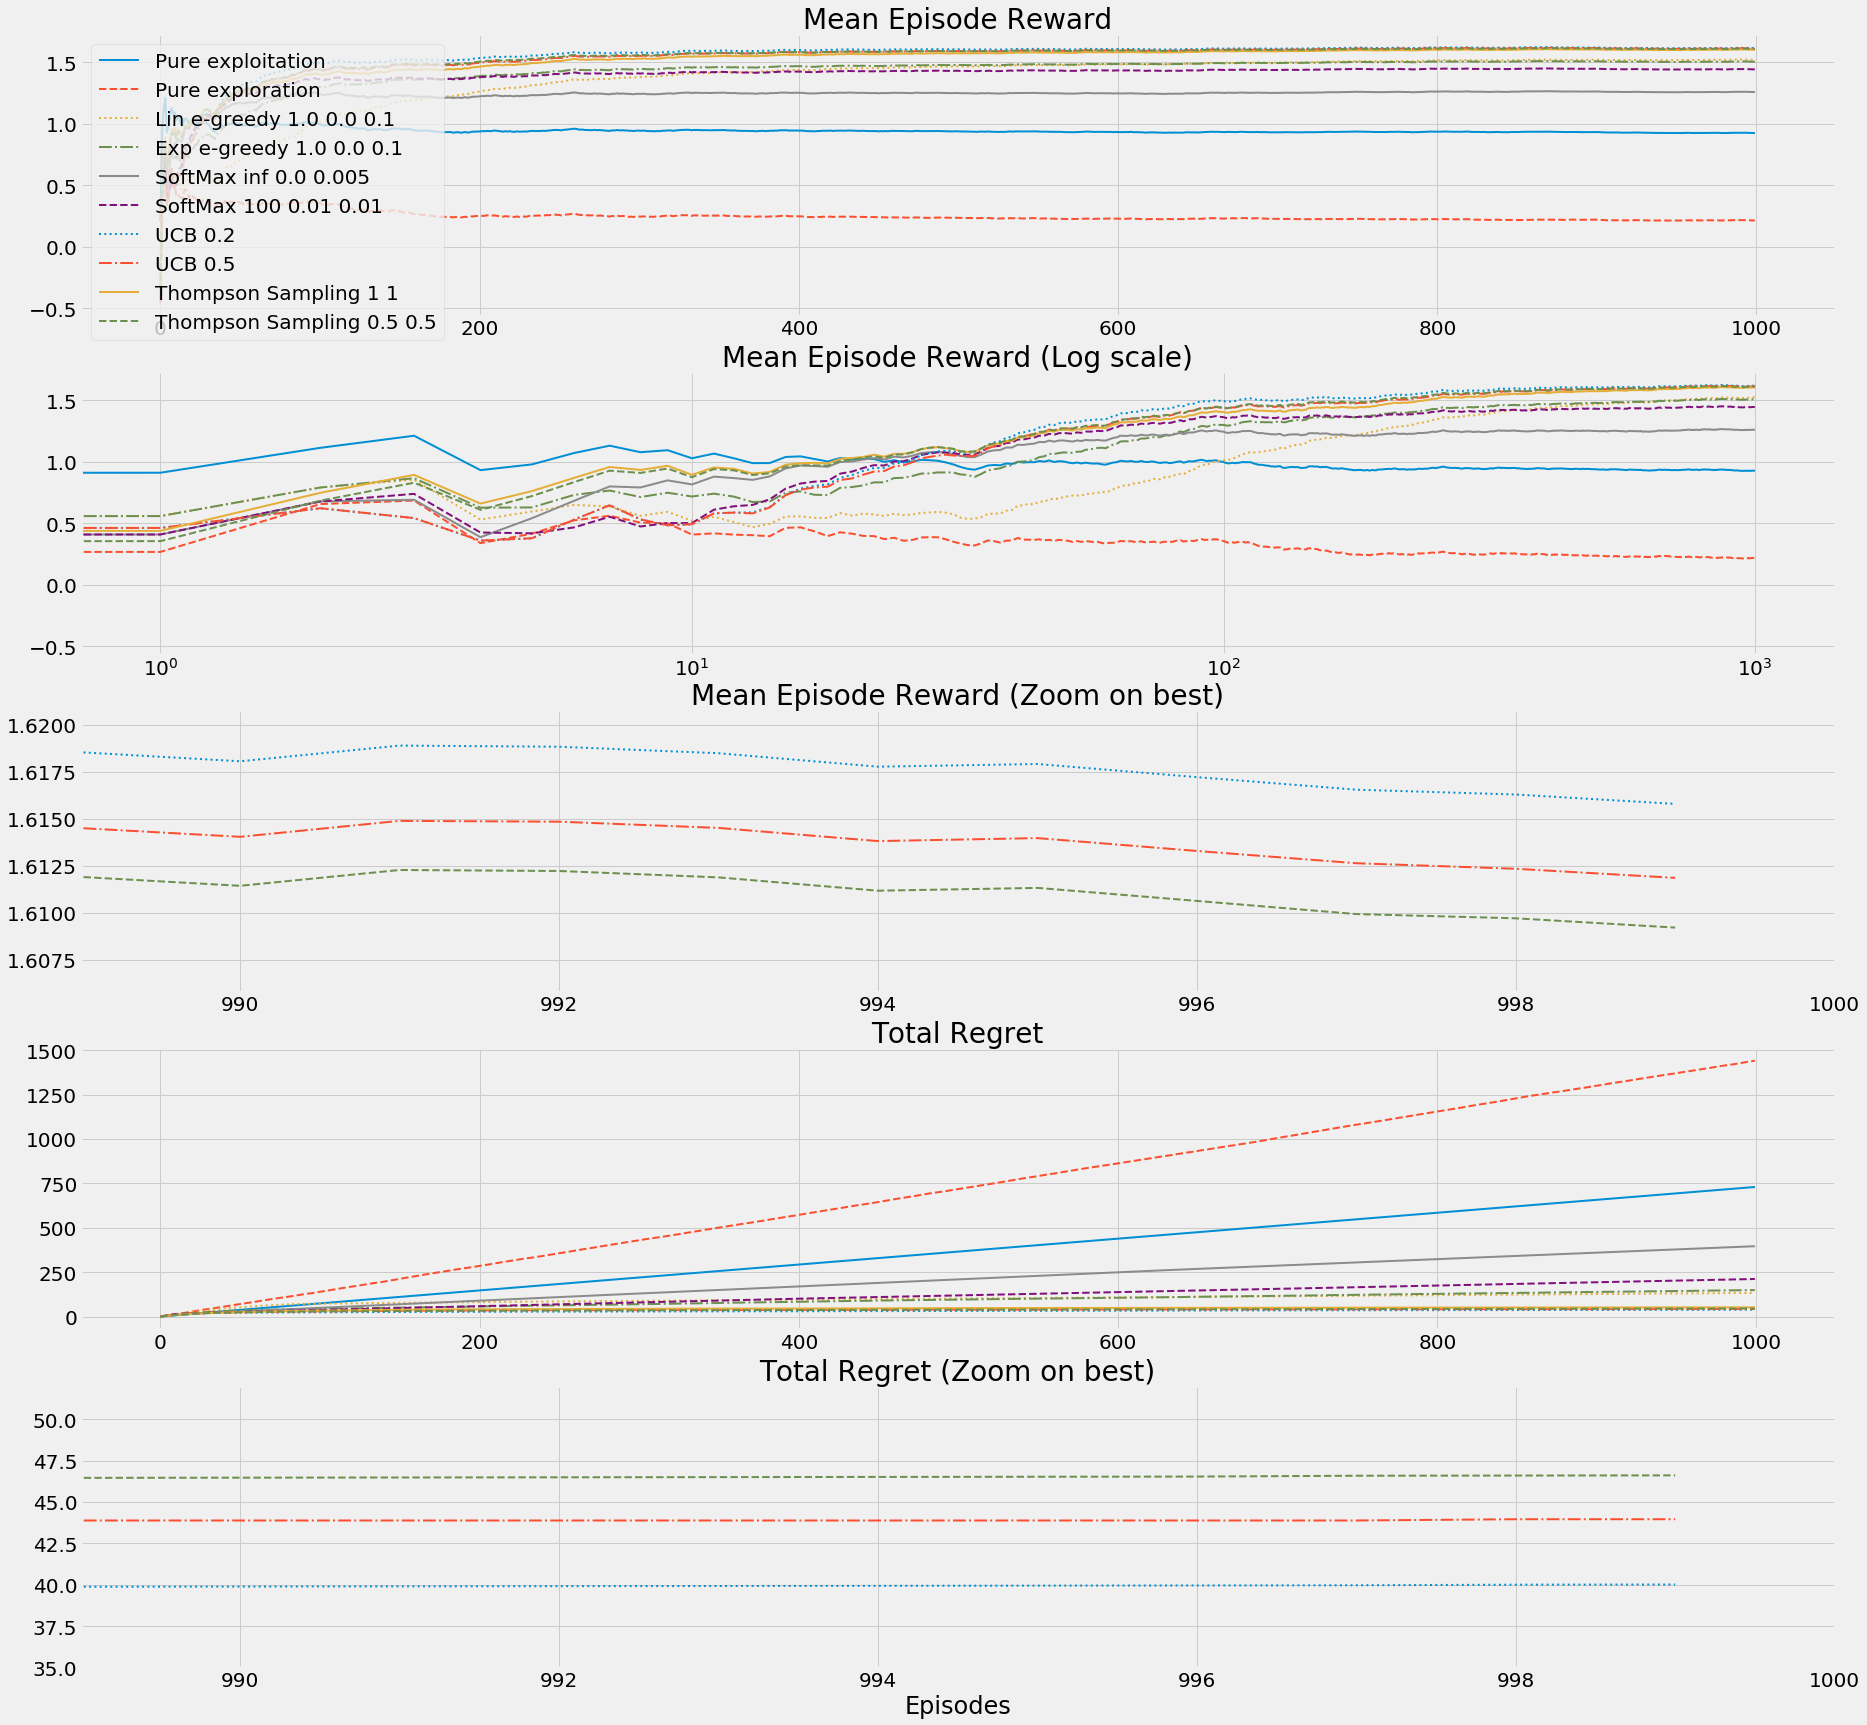

In [22]:
fig, axs = plt.subplots(5, 1, figsize=(28, 28), sharey=False, sharex=False)

lines = ["-","--",":","-."]
linecycler = cycle(lines)
min_reg, max_ret = float('inf'), float('-inf')
for label, result in b10_results_a.items():
    color = next(linecycler)

    # reward
    episode_mean_rew = np.array(result['episode_mean_rew'])
    mean_episode_mean_rew = np.mean(episode_mean_rew, axis=0)

    axs[0].plot(mean_episode_mean_rew, color, linewidth=2, label=label)

    axs[1].plot(mean_episode_mean_rew, color, linewidth=2, label=label)
    axs[1].set_xscale('log')
    
    axs[2].plot(mean_episode_mean_rew, color, linewidth=2, label=label)
    if max_ret < mean_episode_mean_rew[-1]: max_ret = mean_episode_mean_rew[-1]
    axs[2].axis((mean_episode_mean_rew.shape[0]*0.989,
                 mean_episode_mean_rew.shape[0],
                 max_ret-0.01,
                 max_ret+0.005))

    # regret
    cum_regret = np.array(result['cum_regret'])
    mean_cum_regret = np.mean(cum_regret, axis=0)

    axs[3].plot(mean_cum_regret, color, linewidth=2, label=label)
    
    axs[4].plot(mean_cum_regret, color, linewidth=2, label=label)
    if min_reg > mean_cum_regret[-1]: min_reg = mean_cum_regret[-1]
    plt.axis((mean_cum_regret.shape[0]*0.989,
              mean_cum_regret.shape[0],
              min_reg-5,
              min_reg+12))

    # config plot
    axs[0].set_title('Mean Episode Reward')
    axs[1].set_title('Mean Episode Reward (Log scale)')
    axs[2].set_title('Mean Episode Reward (Zoom on best)')
    axs[3].set_title('Total Regret')
    axs[4].set_title('Total Regret (Zoom on best)')
    plt.xlabel('Episodes')
    axs[0].legend(loc='upper left')

plt.show()